In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
import sys
import time
import gc
import matplotlib.pyplot as plt

In [ ]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid



import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **DATASET**

In [ ]:
import zipfile
import urllib.request as request
import os


url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip "


#if already uploaded read from here
if not os.path.exists('tiny-imagenet-200.zip'):
    request.urlretrieve(url,"tiny-imagenet-200.zip")


if not os.path.exists("tiny-imagenet-200"):
    with zipfile.ZipFile("tiny-imagenet-200.zip","r") as f:
        f.extractall()


! ls

sample_data  tiny-imagenet-200	tiny-imagenet-200.zip


We don't have access to the test data labels so we can't evaluate on it.

# **The splits for test and validation is done using training data set only**

In [ ]:
common_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
training_data = ImageFolder('tiny-imagenet-200/train', common_transforms)
torch.manual_seed(42)
train_data, validation_data,testing_data = torch.utils.data.random_split(training_data, [80000, 10000,10000])
len(train_data), len(validation_data), len(testing_data)

(80000, 10000, 10000)

In [ ]:
batch_size=64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(testing_data, batch_size=batch_size, shuffle=False)

In [ ]:
del train_data
del validation_data
del testing_data
del training_data
gc.collect()

31

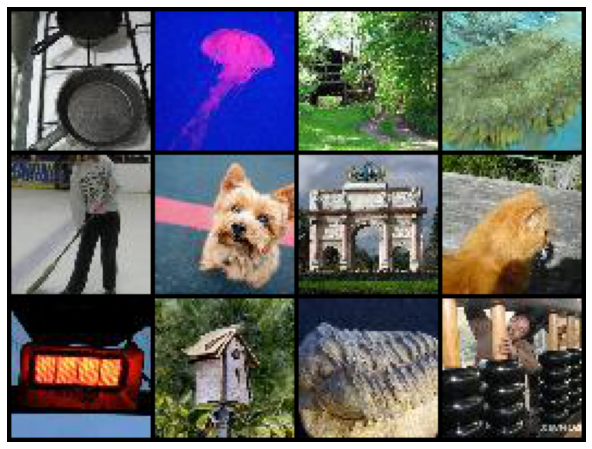

In [ ]:
for images, _ in train_loader:
    # print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images[:12], nrow=4).permute((1, 2, 0)))
    break

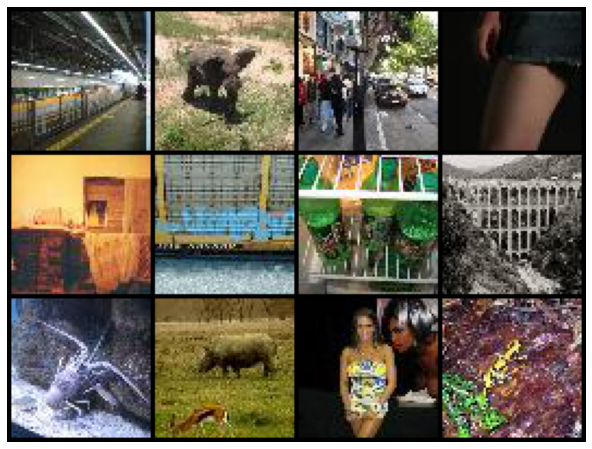

In [ ]:
for images, _ in test_loader:
    # print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images[:12], nrow=4).permute((1, 2, 0)))
    break

# modify the classifier and freeze the layer before that for 

In [ ]:
num_classes = 200
learning_rate = 0.003

In [ ]:
model = torchvision.models.densenet121(pretrained=True)
# print(model)
# print(model.features)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


# **Fine tuning**

In [ ]:
finetune = True

In [ ]:
if not finetune:
    print("Feature extration")
    for param in model.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        nn.Linear(256, num_classes))

    model = model.to(device)


    parameters_to_update = model.parameters()
    parameters_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            parameters_to_update.append(param)
            print("\t",name)

else:
    #finetuning
    model = model.to(device)
    model.classifier = nn.Linear(1024, 200)
    parameters_to_update = model.parameters()
    for name,param in model.named_parameters():
        print("\t",name)

Feature extraction
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias


In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
# optimizer = torch.optim.Adam(parameters_to_update, lr=learning_rate)
optimizer = torch.optim.SGD(parameters_to_update, lr=learning_rate, momentum=0.9)

In [ ]:
path ="/content"
filename ="epoch-fine-tuning"

In [ ]:
import gc
print(gc.collect())

4840


In [ ]:
! pip3 install guppy3
from guppy import hpy

h = hpy()
print(h.heap() )


     |████████████████████████████████| 614kB 12.5MB/s 


/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:126: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


Partition of a set of 2262998 objects. Total size = 187596160 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0 406472  18 47461411  25  47461411  25 str
     1 392877  17 31236104  17  78697515  42 tuple
     2 959762  42 27731464  15 106428979  57 int
     3 120609   5 23156928  12 129585907  69 zipfile.ZipInfo
     4 192667   9 12489142   7 142075049  76 bytes
     5  11530   1  9580048   5 151655097  81 dict (no owner)
     6  36694   2  5308760   3 156963857  84 types.CodeType
     7   9068   0  4809672   3 161773529  86 list
     8  34776   2  4729536   3 166503065  89 function
     9   3995   0  3941752   2 170444817  91 type
<1463 more rows. Type e.g. '_.more' to view.>


In [ ]:
import pickle
import math

In [ ]:
epoch = 0
log_interval = 100  #step size
dataset_size = len(train_loader.dataset) #number of reviews in training dataset
valdata_size = len(val_loader.dataset) #number of reviews in validation dataset
best_accuracy = math.inf
trainLosses,trainAccuracy,validationAccuracy = [],[],[]
validationLoss =[]
clip =5

In [ ]:
nEpochs = 15
start = time.time()
while epoch <= nEpochs:# and not stop_training:

    model.train()
    running_corrects = 0
    running_loss = 0
    for batch_num, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).to(device)
        _,predictions =  torch.max(outputs, 1) #max of the final layer 
        running_corrects += (torch.sum(predictions==labels).item()) #number of right predicitions         
        
        with torch.set_grad_enabled(True):
            loss = criterion(outputs, labels.long())
            loss.backward()
            # nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
        loss_value = loss.detach().item()
        running_loss += loss_value
        if batch_num % log_interval == 0:  #at step size, output batch loss
            
            print('Training Epoch: {0}[{1}/{2} images]\
            Training Loss: {3:.6f}'.format(epoch+1, batch_num * batch_size,dataset_size,loss_value)) 
    gc.collect()
    trainAccuracy.append(running_corrects/len(train_loader))
    trainLosses.append(running_loss/len(train_loader))
    model.eval()
    with torch.set_grad_enabled(False):
        val_losses = 0
        val_accuracy = 0
        for _, (val_batch, val_labels ) in enumerate(val_loader):                    
            val_batch = val_batch.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_batch).to(device)
            val_losses+=(criterion(val_outputs, val_labels.long()).detach().item())
            _, val_predictions = torch.max(val_outputs, 1)
            val_accuracy+=(torch.sum(val_predictions==val_labels).item() )

        validationAccuracy.append(val_accuracy/len(val_loader)) 
        validationLoss.append(val_losses/len(val_loader))
        if validationAccuracy[-1] > best_accuracy:
            best_Accuracy = validationAccuracy[-1]
            best_model_weights = copy.deepcopy(model.state_dict())

    print('After Epoch: {0}\
            Training Loss: {1:.6f}\
            Training Accuracy {2:.6f}\
            Validation Loss: {3:.6f}\
            Validation Accuracy {4:.6f}'.format(epoch+1,trainLosses[-1],trainAccuracy[-1],validationLoss[-1],validationAccuracy[-1])) 
        
                        
    # torch.save(model.state_dict(), path+filename+".pt") 
    with open(path+filename+".pkl","wb") as f:
        pickle.dump([trainLosses,trainAccuracy,validationAccuracy],f)
                                
    epoch = epoch + 1
    
end = time.time()


# model.load_state_dict(best_model_weights)

Training Epoch: 1[0/80000 images]            Training Loss: 3.576034
Training Epoch: 1[6400/80000 images]            Training Loss: 3.839643
Training Epoch: 1[12800/80000 images]            Training Loss: 3.656733
Training Epoch: 1[19200/80000 images]            Training Loss: 4.037443
Training Epoch: 1[25600/80000 images]            Training Loss: 3.629864
Training Epoch: 1[32000/80000 images]            Training Loss: 3.524553
Training Epoch: 1[38400/80000 images]            Training Loss: 3.857792
Training Epoch: 1[44800/80000 images]            Training Loss: 3.662039
Training Epoch: 1[51200/80000 images]            Training Loss: 3.007223
Training Epoch: 1[57600/80000 images]            Training Loss: 3.555554
Training Epoch: 1[64000/80000 images]            Training Loss: 3.574009
Training Epoch: 1[70400/80000 images]            Training Loss: 3.375180
Training Epoch: 1[76800/80000 images]            Training Loss: 2.971595
After Epoch: 1            Training Loss: 3.562621       

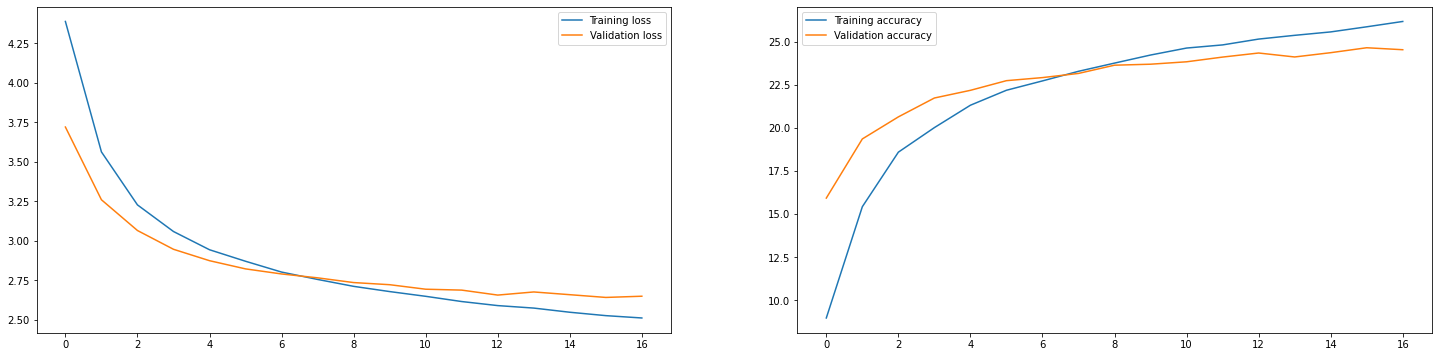

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(25,6))

axes[0].plot(trainLosses,label="Training loss")
axes[0].plot(validationLoss,label="Validation loss")
axes[0].legend()
axes[1].plot(trainAccuracy,label="Training accuracy")
axes[1].plot(validationAccuracy,label="Validation accuracy")

axes[1].legend()
plt.show()

In [ ]:
# # from torchsummary import summary

# # vgg = torchvision.models.vgg16(pretrained=True)
# # summary(vgg, (3, 224, 224))
# class Identity(nn.Module):
#     def __init__(self):
#         super(Indentity,self).__init__()
#     def forward(self,x):
#         return x 

In [ ]:
model.eval()
true = []
pred = []
with torch.no_grad():
    test_loss = 0
    test_accuracy = 0
    for _, (test_batch, test_labels ) in enumerate(test_loader):                    
        # test_batch = test_batch.reshape(sequence_length,batch_size ,input_size).to(device)
    
        test_batch = test_batch.to(device)
        test_labels = test_labels.to(device)
        test_outputs = model(test_batch).to(device)
        test_loss+= (criterion(test_outputs, test_labels.long()).detach().item())
        _, test_predictions = torch.max(test_outputs, 1)
        test_accuracy+=(torch.sum(test_predictions==test_labels).item())
        
        true.extend(test_labels)
        pred.extend(test_predictions)

In [ ]:
print("Test loss is",test_loss/len(test_loader))
print("Accuracy is",test_accuracy/len(test_loader))

Test loss is 2.6107593258475044
Accuracy is 25.547770700636942


In [ ]:
# roc = roc_curve(true,pred)
# print(auc(roc))

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, num_classes = 2):

        super(FocalLoss,self).__init__()        
        self.alpha = torch.zeros(num_classes)
        self.alpha[0] = alpha
        self.alpha[1] = 1-alpha
        self.gamma = gamma

    def forward(self, output, actual):
        output = output.view(-1,output.size(-1))
        self.alpha = self.alpha.to(output.device)
        logsoftmax = F.log_softmax(output, dim=1) # log_softmax
        softmax = torch.exp(logsoftmax)    # softmax
        softmax = softmax.gather(1,actual.view(-1,1))  
        logsoftmax = logsoftmax.gather(1,actual.view(-1,1))
        self.alpha = self.alpha.gather(0,actual.view(-1))
        
        loss = -torch.mul(torch.pow((1-softmax), self.gamma), logsoftmax) 
        loss = torch.mul(self.alpha, loss.t())
        return loss.mean()

In [ ]:
fc_model = torchvision.models.densenet121(pretrained=True)
# print(model)
# print(model.features)


fc_model.classifier = nn.Linear(1024, 200)
parameters_to_update = fc_model.parameters()
for name,param in fc_model.named_parameters():
    print("\t",name)

In [ ]:
learning_rate = 0.003
fc_model = fc_model.to(device)
fc_criterion = FocalLoss(alpha=0.25, gamma=2, num_classes=2).to(device)
# optimizer = torch.optim.Adam(parameters_to_update, lr=learning_rate)
optimizer = torch.optim.SGD(parameters_to_update, lr=learning_rate, momentum=0.9)

In [ ]:
import math

In [ ]:
nEpochs = 15
epoch = 0
log_interval = 100  #step size
dataset_size = len(train_loader.dataset) #number of reviews in training dataset
valdata_size = len(val_loader.dataset) #number of reviews in validation dataset
best_accuracy = math.inf
trainLosses,trainAccuracy,validationAccuracy = [],[],[]
validationLoss =[]
clip =1

In [ ]:
nEpochs = 15
start = time.time()
while epoch <= nEpochs:# and not stop_training:

    fc_model.train()
    running_corrects = 0
    running_loss = 0
    for batch_num, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = fc_model(images).to(device)
        _,predictions =  torch.max(outputs, 1) #max of the final layer 
        running_corrects += (torch.sum(predictions==labels).item()) #number of right predicitions         
        
        with torch.set_grad_enabled(True):    
            loss = fc_criterion(outputs, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(fc_model.parameters(), clip)
            optimizer.step()
        loss_value = loss.detach().item()
        running_loss += loss_value
        if batch_num % log_interval == 0:  #at step size, output batch loss
            
            print('Training Epoch: {0}[{1}/{2} images]\
            Training Loss: {3:.6f}'.format(epoch+1, batch_num * batch_size,dataset_size,loss_value)) 
    gc.collect()
    trainAccuracy.append(running_corrects/len(train_loader))
    trainLosses.append(running_loss/len(train_loader))
    fc_model.eval()
    with torch.set_grad_enabled(False):
        val_losses = 0
        val_accuracy = 0
        for _, (val_batch, val_labels ) in enumerate(val_loader):                    
            val_batch = val_batch.to(device)
            val_labels = val_labels.to(device)
            val_outputs = fc_model(val_batch).to(device)
            val_losses+=(fc_criterion(val_outputs, val_labels.long()).detach().item())
            _, val_predictions = torch.max(val_outputs, 1)
            val_accuracy+=(torch.sum(val_predictions==val_labels).item() )

        validationAccuracy.append(val_accuracy/len(val_loader)) 
        validationLoss.append(val_losses/len(val_loader))
        if validationAccuracy[-1] > best_accuracy:
            best_Accuracy = validationAccuracy[-1]
            best_model_weights = copy.deepcopy(fc_model.state_dict())

    print('After Epoch: {0}\
            Training Loss: {1:.6f}\
            Training Accuracy {2:.6f}\
            Validation Loss: {3:.6f}\
            Validation Accuracy {4:.6f}'.format(epoch+1,trainLosses[-1],trainAccuracy[-1],validationLoss[-1],validationAccuracy[-1])) 
        
                        
    # torch.save(fc_model.state_dict(), path+filename+".pt") 
    with open(path+filename+".pkl","wb") as f:
        pickle.dump([trainLosses,trainAccuracy,validationAccuracy],f)
                                
    epoch = epoch + 1
    
end = time.time()


# fc_model.load_state_dict(best_model_weights)

In [ ]:
fc_model.eval()
true = []
pred = []
with torch.no_grad():
    test_loss = 0
    test_accuracy = 0
    for _, (test_batch, test_labels ) in enumerate(test_loader):                    
        # test_batch = test_batch.reshape(sequence_length,batch_size ,input_size).to(device)    
        test_batch = test_batch.to(device)
        test_labels = test_labels.to(device)
        test_outputs = fc_model(test_batch).to(device)
        test_loss+= (criterion(test_outputs, test_labels.long()).detach().item() * test_batch.size(0))
        _, test_predictions = torch.max(test_outputs, 1)
        test_accuracy+=(torch.sum(test_predictions==test_labels).item())
        
        true.extend(test_labels)
        pred.extend(test_predictions)

In [ ]:
print("Test loss is",test_loss/len(test_loader.dataset))
print("Accuracy is",test_accuracy/len(test_loader.dataset))